In [91]:
%matplotlib inline
import dashed_dreams.DASH.src.data.ts_datasets as my 
import statsforecast as sf
import statsforecast.models as sfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import models
import importlib
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm

# from embedder import wrapper1D
# from attrdict import AttrDict
# from task_configs import get_config
# from main import load_state
# import yaml

train_loader, val_loader, test_loader = my.get_timeseries_dataloaders("./datasets/all_six_datasets/traffic/traffic.csv", 32)
train_data, val_data, test_data = train_loader.dataset, val_loader.dataset, test_loader.dataset

train_df, val_df, test_df = pd.DataFrame(train_data.data), pd.DataFrame(val_data.data), pd.DataFrame(test_data.data)

# train_df = all_df.iloc[0:int(n * train_prop), :]
# val_df = all_df.iloc[int(n * train_prop):int(n * (train_prop + val_prop)), :]
# test_df = all_df.iloc[int(n * (train_prop + val_prop)): , :]

# scaler = StandardScaler().fit(train_df.iloc[:, 1:])
# train_df.iloc[:, 1:] = scaler.transform(train_df.iloc[:, 1:])
# val_df.iloc[:, 1:] = scaler.transform(val_df.iloc[:, 1:])
# test_df.iloc[:, 1:] = scaler.transform(test_df.iloc[:, 1:])
# train_df = train_df.iloc[:2000, :]
# test_df = test_df.iloc[:2000, :]

# train_df = pd.melt(train_df, id_vars=['date'])
# val_df = pd.melt(val_df, id_vars=['date'])
# test_df = pd.melt(test_df, id_vars=['date'])

# train_df.columns = ['ds', 'unique_id', 'y']
# val_df.columns = ['ds', 'unique_id', 'y']
# test_df.columns = ['ds', 'unique_id', 'y']


In [101]:
importlib.reload(models)
test = models.ARv2(512, 96)
# test.fit_preset(pd.concat((train_df, val_df)), 512, False, torch.device("cpu"), True)
test.fit_preset(train_df, 512, False, torch.device("cpu"), True)
test.test_loss_acc_df(test_df, torch.device("cpu"))

Selected Lags: 512


(0.3898707926273346, 0.2669685184955597)

In [72]:
test.fit(train_df, val_df, 5.5)

In [ ]:
test.fit_raw(train_df, val_df, torch.device("cuda:0"), 5.5, False, True)

In [69]:
test.betas = test.betas * 0.95
test.test_loss_acc_df(test_df, torch.device("cpu"))

(0.9404816031455994, 0.7096893787384033)

In [74]:
test.betas

tensor([[-0.0015, -0.0025, -0.0035,  ..., -0.0264, -0.0265, -0.0267],
        [ 0.7368,  0.6950,  0.6228,  ...,  0.0937,  0.1245,  0.2434],
        [ 0.1521,  0.1108,  0.0910,  ...,  0.0554,  0.1516,  0.0606],
        ...,
        [ 0.0015, -0.0096,  0.0425,  ..., -0.0100, -0.0125,  0.0051],
        [-0.0168,  0.0373, -0.0173,  ..., -0.0130,  0.0040,  0.0011],
        [ 0.0200, -0.0257, -0.0133,  ...,  0.0030, -0.0018, -0.0043]])

In [55]:
importlib.reload(models)
meep = test._unfold_df(train_df, torch.device("cuda:0"), 512, 1)

In [38]:
len(val_data)

814056

In [39]:
val_df.shape

(3143, 321)

In [56]:
meep.shape

torch.Size([321, 15270, 513])

In [57]:
from sklearn.linear_model import LinearRegression

test_lr = LinearRegression().fit(meep.cpu().view(321 * 15270, 513)[:, :512], meep.cpu().view(321 * 15270, 513)[:, 512])

In [59]:
X = meep.reshape(321 * 15270, 513)[:, :512]

In [64]:
torch.inverse(torch.matmul(torch.transpose(X, 1, 0), X))

tensor([[ 3.9430e-06, -2.6438e-06, -1.6830e-07,  ..., -2.3519e-09,
          7.9223e-09,  2.4003e-08],
        [-2.6438e-06,  5.7184e-06, -2.5331e-06,  ...,  3.8350e-08,
         -6.6101e-09,  7.7901e-09],
        [-1.6830e-07, -2.5331e-06,  5.7271e-06,  ..., -3.4867e-09,
          3.8370e-08, -2.3407e-09],
        ...,
        [-2.3506e-09,  3.8354e-08, -3.4906e-09,  ...,  5.8167e-06,
         -2.5646e-06, -1.7440e-07],
        [ 7.9235e-09, -6.6210e-09,  3.8374e-08,  ..., -2.5646e-06,
          5.8089e-06, -2.6808e-06],
        [ 2.4002e-08,  7.7934e-09, -2.3417e-09,  ..., -1.7441e-07,
         -2.6808e-06,  4.0223e-06]], device='cuda:0')

In [41]:
torch.prod(torch.tensor(meep.shape)) * 4

tensor(1979784192)

In [1]:
import pandas as pd
raw_illness_df = pd.read_csv(
        "./datasets/all_six_datasets/illness/national_illness.csv"
    )

In [21]:
n = len(raw_illness_df)
n_train = int(0.7*n)

mean = raw_illness_df.iloc[:n_train, 1:].mean()
std = raw_illness_df.iloc[:n_train, 1:].std(ddof=0)

scaled_illness_df = (raw_illness_df.iloc[:, 1:] - mean)/std

x, y = train_data[0]

In [15]:
scaled_illness_df

,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,-0.421499,-0.472442,-0.981641,-0.692621,-0.819695,-1.151274,-1.385709
1,-0.331239,-0.429154,-0.934213,-0.676837,-0.796703,-1.088458,-1.342939
2,-0.342763,-0.503817,-0.953466,-0.675424,-0.806811,-0.995247,-1.316218
3,-0.199782,-0.397909,-0.913082,-0.636083,-0.759827,-0.930404,-1.250473
4,-0.218426,-0.354542,-0.868472,-0.602160,-0.725617,-0.837193,-1.181873
...,...,...,...,...,...,...,...
961,-0.733899,-0.750450,0.039232,-0.051154,0.385771,3.922647,4.507846
962,-0.687557,-0.696437,0.249136,0.007739,0.504174,3.914542,4.564575
963,-0.675366,-0.667990,0.378271,0.011979,0.549714,3.758514,4.521154
964,-0.646029,-0.641436,0.498485,0.017162,0.617468,3.533592,4.585444


In [24]:
x[0][0].item()

-0.42149871587753296

In [25]:
scaled_illness_df.iloc[0, 0]

-0.4214987224127662

In [103]:
import pickle as pkl
import numpy as np
with open("baseline_results.pkl", 'rb') as file:
    test = pkl.load(file)

In [105]:
test['Weather']['ar_d1']

{192: (0.213350310921669,
  0.270438551902771,
  (219.61146835203593, 'Reached Time Limit? False', 'Best Lags 481')),
 96: (0.17093272507190704,
  0.2303556352853775,
  (104.8974100103369, 'Reached Time Limit? False', 'Best Lags 484')),
 336: (0.25869694352149963,
  0.3094922602176666,
  (153.8091962774284, 'Reached Time Limit? False', 'Best Lags 512')),
 720: (0.32810473442077637,
  0.37082865834236145,
  (215.01896216251578, 'Reached Time Limit? False', 'Best Lags 512'))}

In [21]:
test_df.shape

(3392, 7)

100%|██████████| 19495/19495 [00:02<00:00, 8768.03it/s]


1.114777591345567 0.8060858187523414


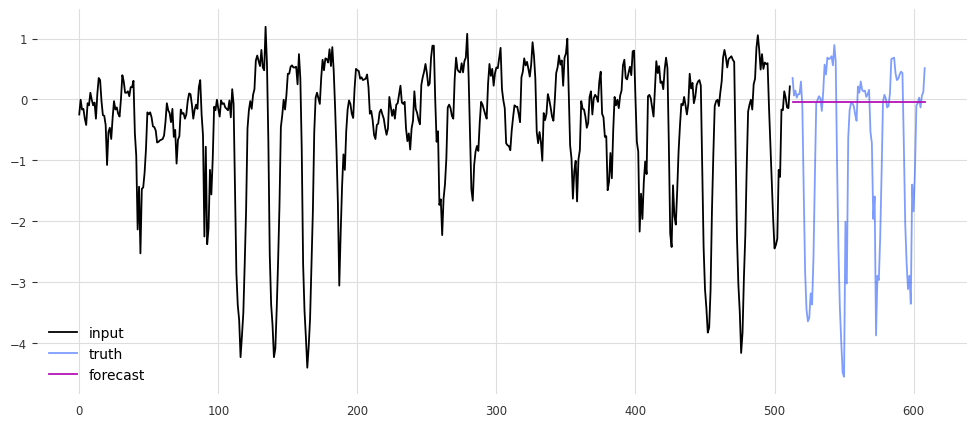

In [ ]:
gm = GlobalMean(512, 96)
gm.fit_raw(train_df, val_df)
gm_mse, gm_mae = gm.test_loss_acc(test_data)
gm.plot_predictions(test_data[0][0], test_data[0][1])

print(np.mean(gm_mse), np.mean(gm_mae))

100%|██████████| 512/512 [01:13<00:00,  7.01it/s]


Selected Window Size: 48


100%|██████████| 19495/19495 [02:48<00:00, 115.50it/s]


0.71434546 0.5617913


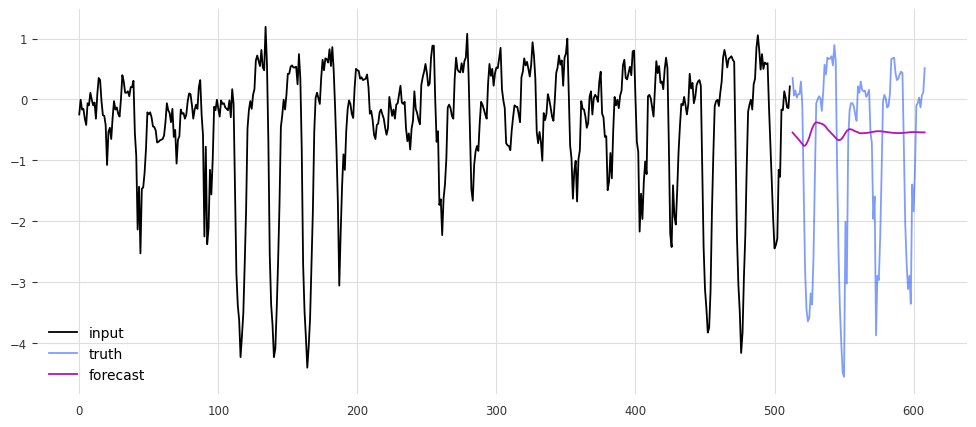

In [ ]:
wm = MovingAverage(512, 96)
wm.fit_raw(train_df, val_df)
wm_mse, wm_mae = wm.test_loss_acc(test_data)
wm.plot_predictions(test_data[0][0], test_data[0][1])
print(np.mean(wm_mse), np.mean(wm_mae))

Selected Lags: 457


100%|██████████| 96/96 [00:04<00:00, 19.95it/s]


0.3681361207146698 0.39297121464204304


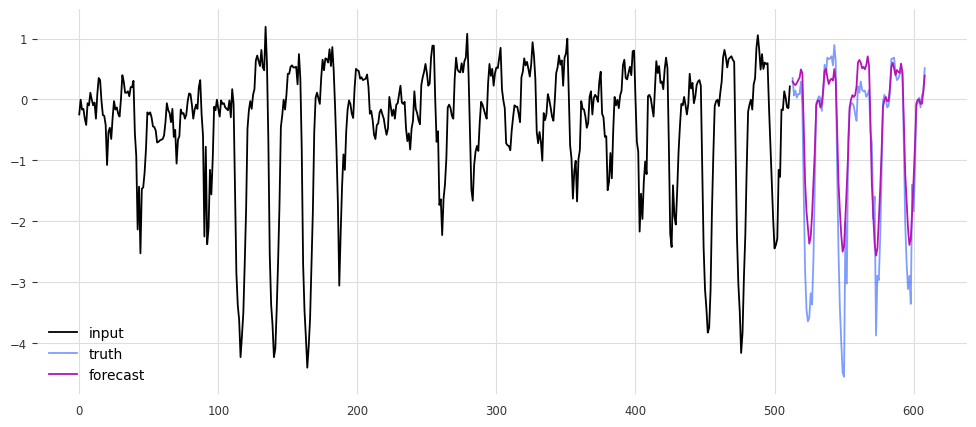

In [ ]:
ar = AR(512, 96)
# ar.fit_raw(train_df, val_df, None)
ar.fit_preset(train_df, 457)
ar_mse, ar_mae = ar.test_loss_acc(test_data)
ar.plot_predictions(test_data[0][0], test_data[0][1])
print(np.mean(ar_mse), np.mean(ar_mae))

In [11]:
len(train_loader)

1758

In [12]:
import importlib 
importlib.reload(models)

torch.manual_seed(132)
dumb_mlp = models.DumbMLP4TS(512, 96, torch.device("cuda:0"), "test.pt")
dumb_mlp.fit_loader(train_loader, val_loader, 1e-5, 200, 5.5, epoch_batches=10)
dumb_mlp.load_last_state()
dumb_mlp.mlp.eval()
mlp_mse, mlp_mae = dumb_mlp.test_loss_acc_loader(test_loader, dumb_mlp.device)
data_id = 100
dumb_mlp.plot_predictions(test_data[data_id][0].to(dumb_mlp.device), test_data[data_id][1].to(dumb_mlp.device))
print(np.mean(mlp_mse), np.mean(mlp_mae))            

5.5 hours limit


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:03<12:54,  3.89s/it]

Train MSE: 1.2912 | Val MSE: 1.9704 | Val MAE: 1.0161


  3%|▎         | 6/200 [00:11<06:59,  2.16s/it]

Train MSE: 1.0962 | Val MSE: 1.8051 | Val MAE: 0.9737


  6%|▌         | 11/200 [00:19<06:33,  2.08s/it]

Train MSE: 0.9597 | Val MSE: 1.6901 | Val MAE: 0.9428


  6%|▋         | 13/200 [00:22<05:17,  1.70s/it]


KeyboardInterrupt: 

In [ ]:
test_data[data_id][0][-simple_dart.input_length:].shape

tensor([[-0.1556, -0.2824, -0.0173, -0.0750, -0.0634, -0.1326, -0.1556, -0.1787,
         -0.0173, -0.2940,  0.1669, -0.0750, -1.4117, -2.8520, -3.3820, -3.6241,
         -4.2348, -3.8892, -3.5088, -2.7023, -1.8149, -0.4784, -0.1787, -0.0289,
         -0.1556,  0.0747,  0.1669,  0.6395,  0.7200,  0.6280,  0.5473,  0.8122,
          0.5242,  0.4781,  1.1926,  0.5819, -0.6857, -2.5524, -3.3706, -3.7047,
         -4.2348, -4.0965, -3.4512, -2.6677, -1.7342, -0.4553, -0.2594, -0.0058,
         -0.1672,  0.0747,  0.4205,  0.4205,  0.5358,  0.5588,  0.5242,  0.5242,
          0.5358,  0.2476,  0.7431,  0.3398, -0.8125, -2.7138, -3.4742, -3.9122,
         -4.4077, -4.0619, -3.6010, -2.7023, -1.8495, -0.5358,  0.0288,  0.1093,
          0.0172, -0.0750,  0.3513,  0.6509,  0.4781,  0.6739,  0.6624,  0.6049,
          0.8238,  0.5473,  0.8583,  0.4666, -0.1326, -0.8355, -1.6997, -3.0594,
         -2.1953, -1.4347, -0.9047, -1.1581, -0.5243, -0.1672, -0.0173, -0.0750,
         -0.2363, -0.3055,  

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 32.4 K
5 | linear_trend    | Linear           | 32.4 K
-----------------------------------------------------
64.7 K    Trainable params
0         Non-trainable params
64.7 K    Total p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

0.4043141401093567 0.42829808954666476


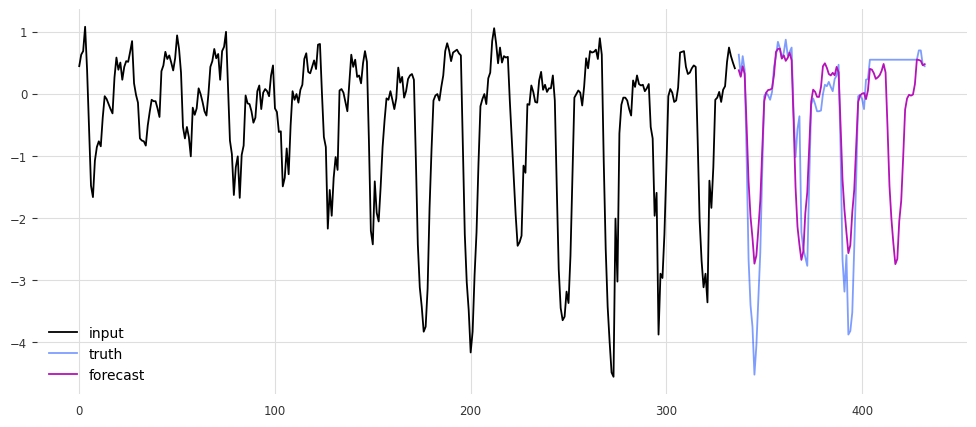

In [ ]:
torch.manual_seed(132)
simple_dart = SimpleDLinear(336, 96)
simple_dart.fit_raw(train_df, val_df, 10, 1e-4)
# simple_dart.load_state("2024-04-04_01_34_08_torch_model_run_83994")
# simple_dart.load_state("2024-04-16_18_46_06_torch_model_run_448626")
# dl_mse, dl_mae = simple_dart.test_loss_acc(test_data)
data_id = 100
simple_dart.plot_predictions(test_data[data_id][0][:, -simple_dart.input_length:], test_data[data_id][1])
print(np.mean(dl_mse), np.mean(dl_mae))

In [ ]:
test_data[0][0][0].view(test_data[0][0][0].shape[0], -1)

tensor([[-0.2479],
        [-0.0058],
        [-0.1672],
        [-0.1556],
        [-0.3170],
        [-0.4208],
        [-0.0634],
        [-0.0980],
        [ 0.1093],
        [-0.0058],
        [-0.0980],
        [-0.0519],
        [-0.3170],
        [ 0.0862],
        [ 0.3513],
        [ 0.3168],
        [-0.0289],
        [-0.2594],
        [-0.2709],
        [-0.4208],
        [-1.0776],
        [-0.5358],
        [-0.4669],
        [-0.6511],
        [-0.3055],
        [-0.0289],
        [-0.1672],
        [-0.1326],
        [-0.2363],
        [-0.2824],
        [ 0.0057],
        [ 0.3974],
        [ 0.2937],
        [ 0.1093],
        [ 0.1093],
        [ 0.1323],
        [ 0.0518],
        [ 0.2015],
        [ 0.2015],
        [ 0.3052],
        [-0.5589],
        [-0.9277],
        [-2.1377],
        [-1.4347],
        [-2.5294],
        [-1.4693],
        [-1.4463],
        [-1.2042],
        [-0.8125],
        [-0.2133],
        [-0.2479],
        [-0.2133],
        [-0.

target_seq_len 256


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5206973973171038 0.5169868494706693


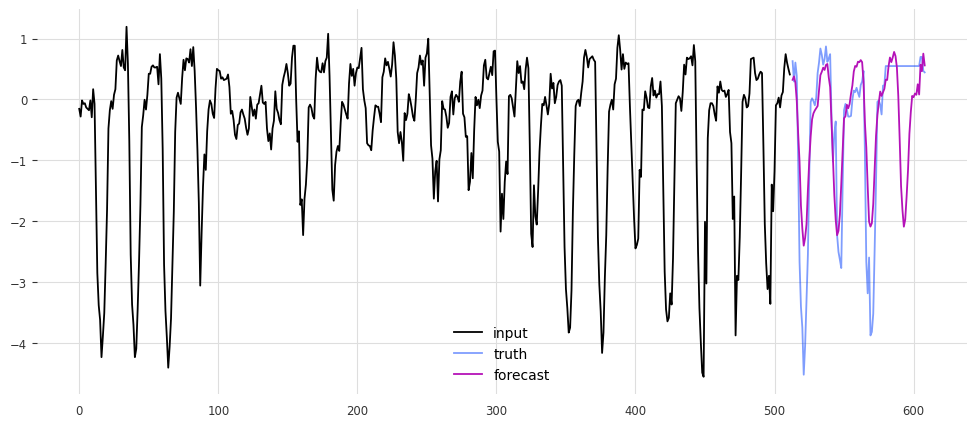

In [ ]:
orca = ORCA(512, 96, "./configs/alex_test_ts.yaml", torch.device("cuda:0"))
orca_mse, orca_mae = orca.test_loss_acc_loader(test_loader, orca.device)
data_id = 100
orca.plot_predictions(test_data[data_id][0], test_data[data_id][1])
print(np.mean(orca_mse), np.mean(orca_mae))

# Plotting

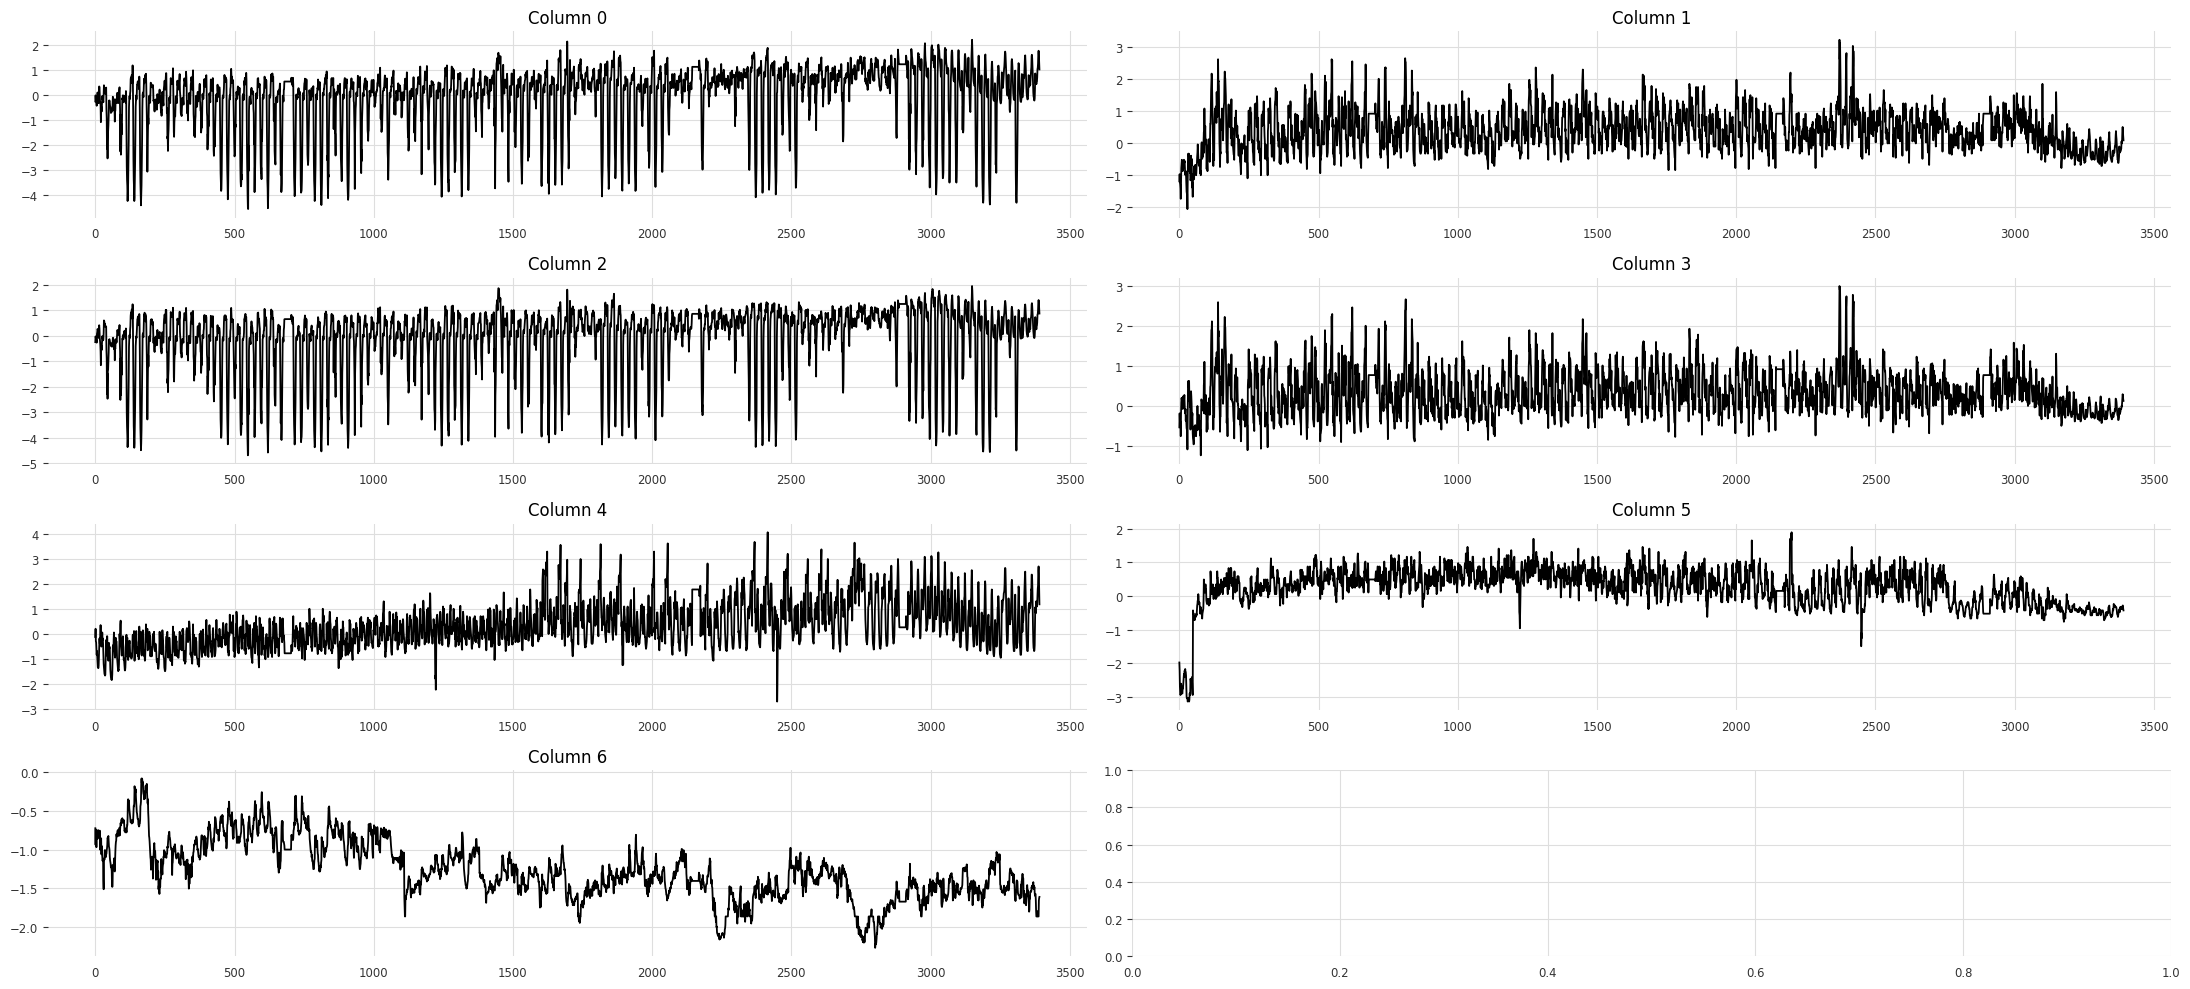

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(22, 10))
ax = ax.flatten()

for i, col in enumerate(test_df.columns):
    ax[i].plot(test_df[col])
    ax[i].set_title(f"Column {col}")

fig.tight_layout()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

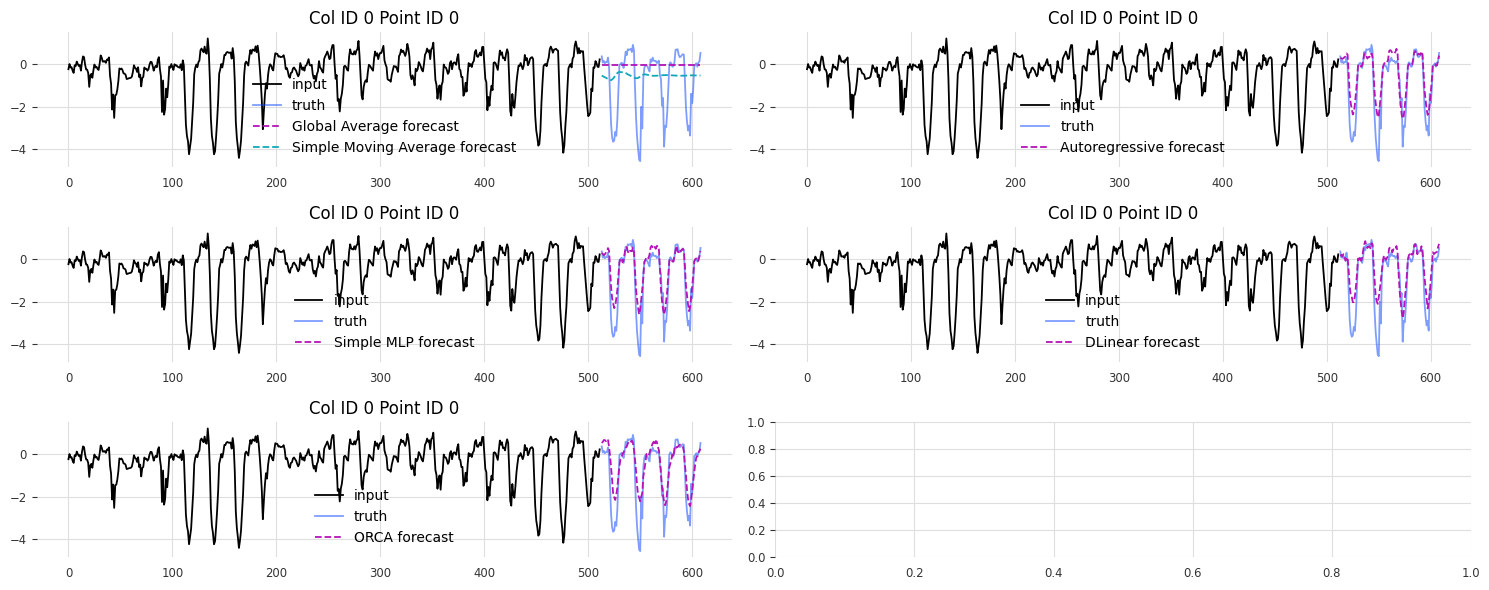

In [ ]:
models = [gm, wm, ar, dumb_mlp, simple_dart, orca]
model_names = ["Global Average", "Simple Moving Average", "Autoregressive", "Simple MLP", "DLinear", "ORCA"]
def plot_predictions(test_ds, col_id, point_id, models, model_names):
    with torch.no_grad():
        data_length = len(test_ds)/7
        data_id = int(col_id * data_length + point_id)
        ts_input = test_ds[data_id][0]
        truth = test_ds[data_id][1]
        i = 0
        model_map = {0: 0, 1: 0, 2: 1, 3: 2, 4:3, 5:4}
        plotted_ids = list()
        fig, ax = plt.subplots(3, 2, figsize=(15, 6))
        ax = ax.flatten()
        for model, model_name in zip(models, model_names):
            ax_id = model_map[i]
            if ax_id not in plotted_ids:
                ax[ax_id].plot(ts_input.flatten(), label="input")
                ax[ax_id].plot(range(model.input_length + 1, model.input_length + model.output_length + 1), truth.flatten(), label="truth", alpha=0.5)
                plotted_ids.append(ax_id)
            preds = model.predict(ts_input).cpu()
            ax[ax_id].plot(range(model.input_length + 1, model.input_length + model.output_length + 1), preds.flatten(), label=f"{model_name} forecast", linestyle="dashed")
            ax[ax_id].legend()
            ax[ax_id].set_title(f"Col ID {col_id} Point ID {point_id}")
            i += 1
        fig.tight_layout()

plot_predictions(test_data, 0, 0, models, model_names)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

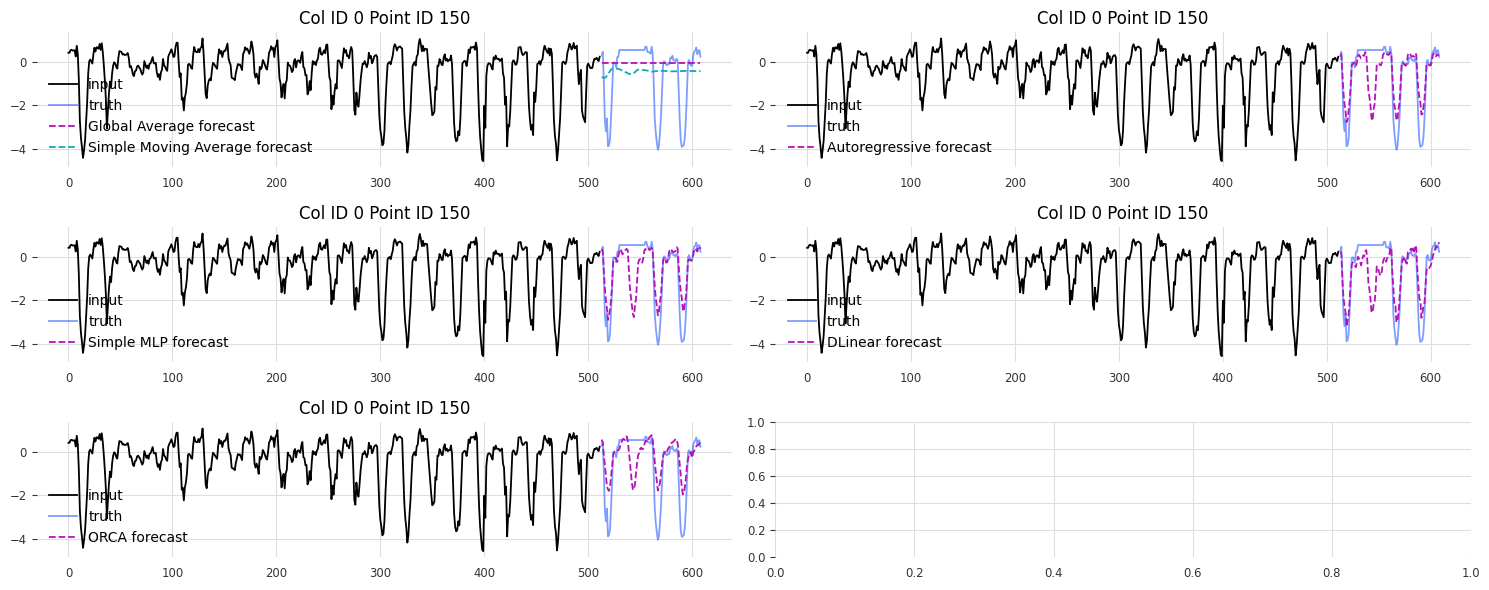

In [ ]:
plot_predictions(test_data, 0, 150, models, model_names)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

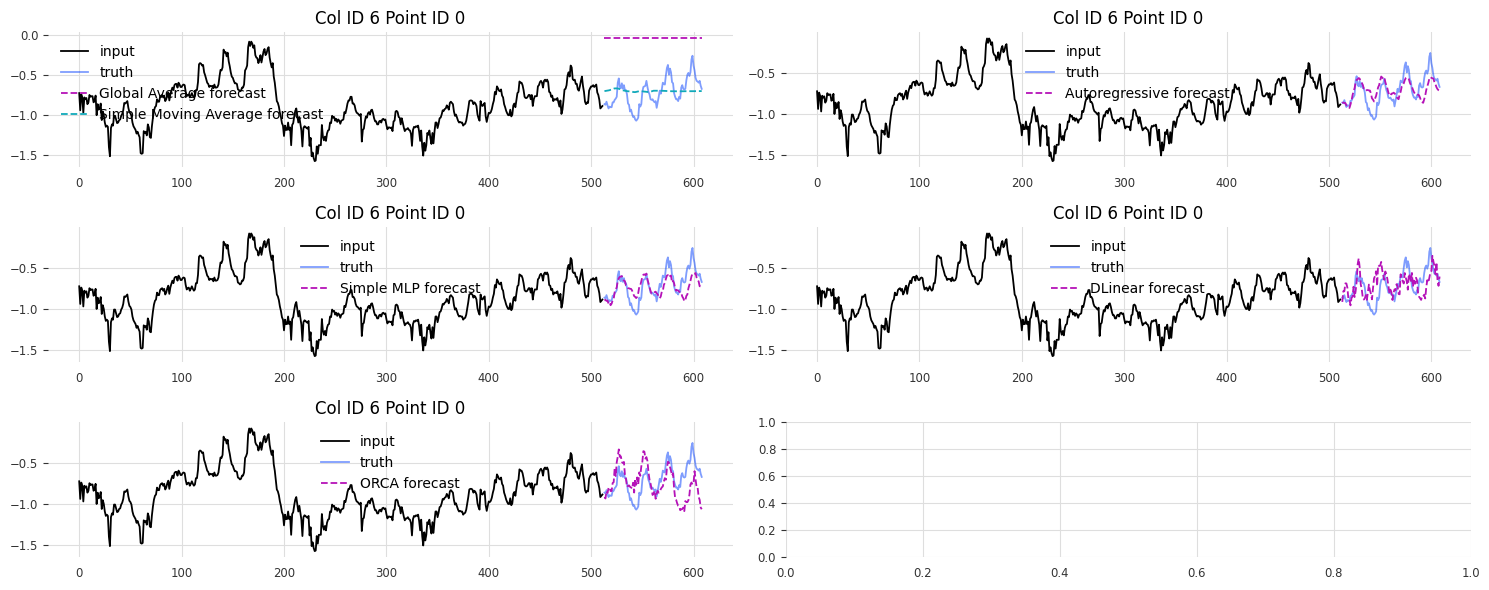

In [ ]:
plot_predictions(test_data, 6, 0, models, model_names)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

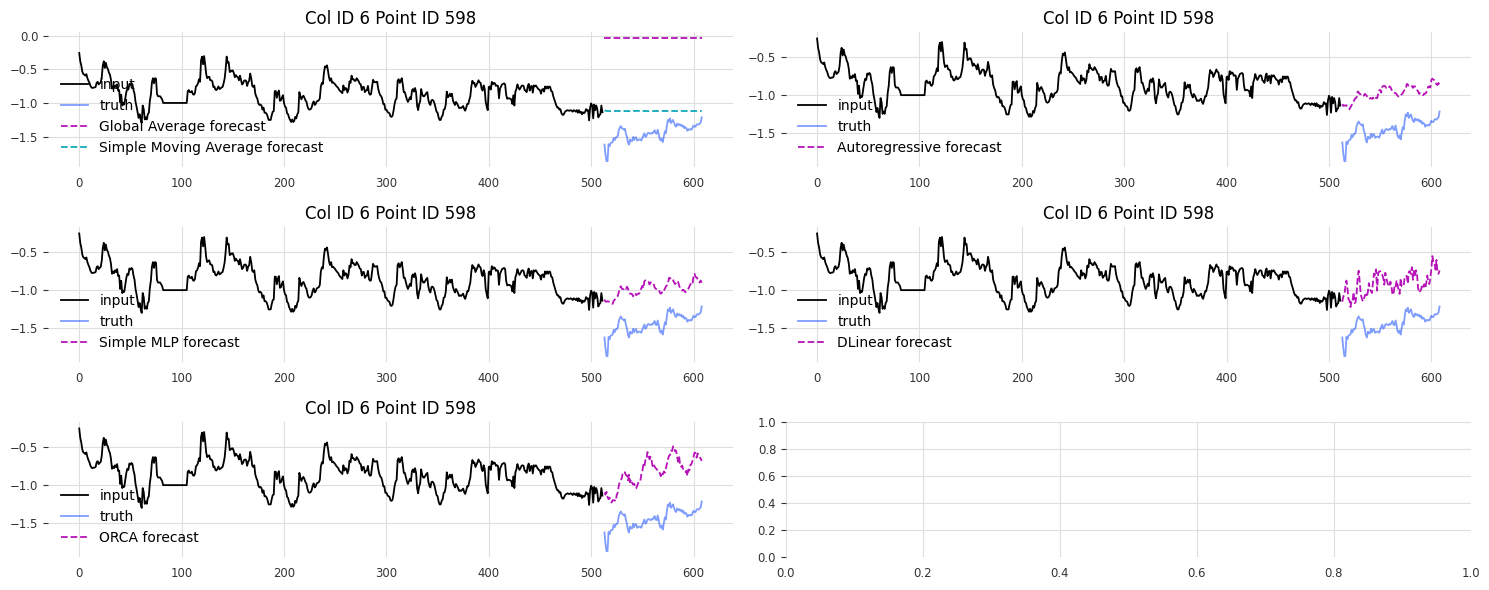

In [ ]:
plot_predictions(test_data, 6, 598, models, model_names)

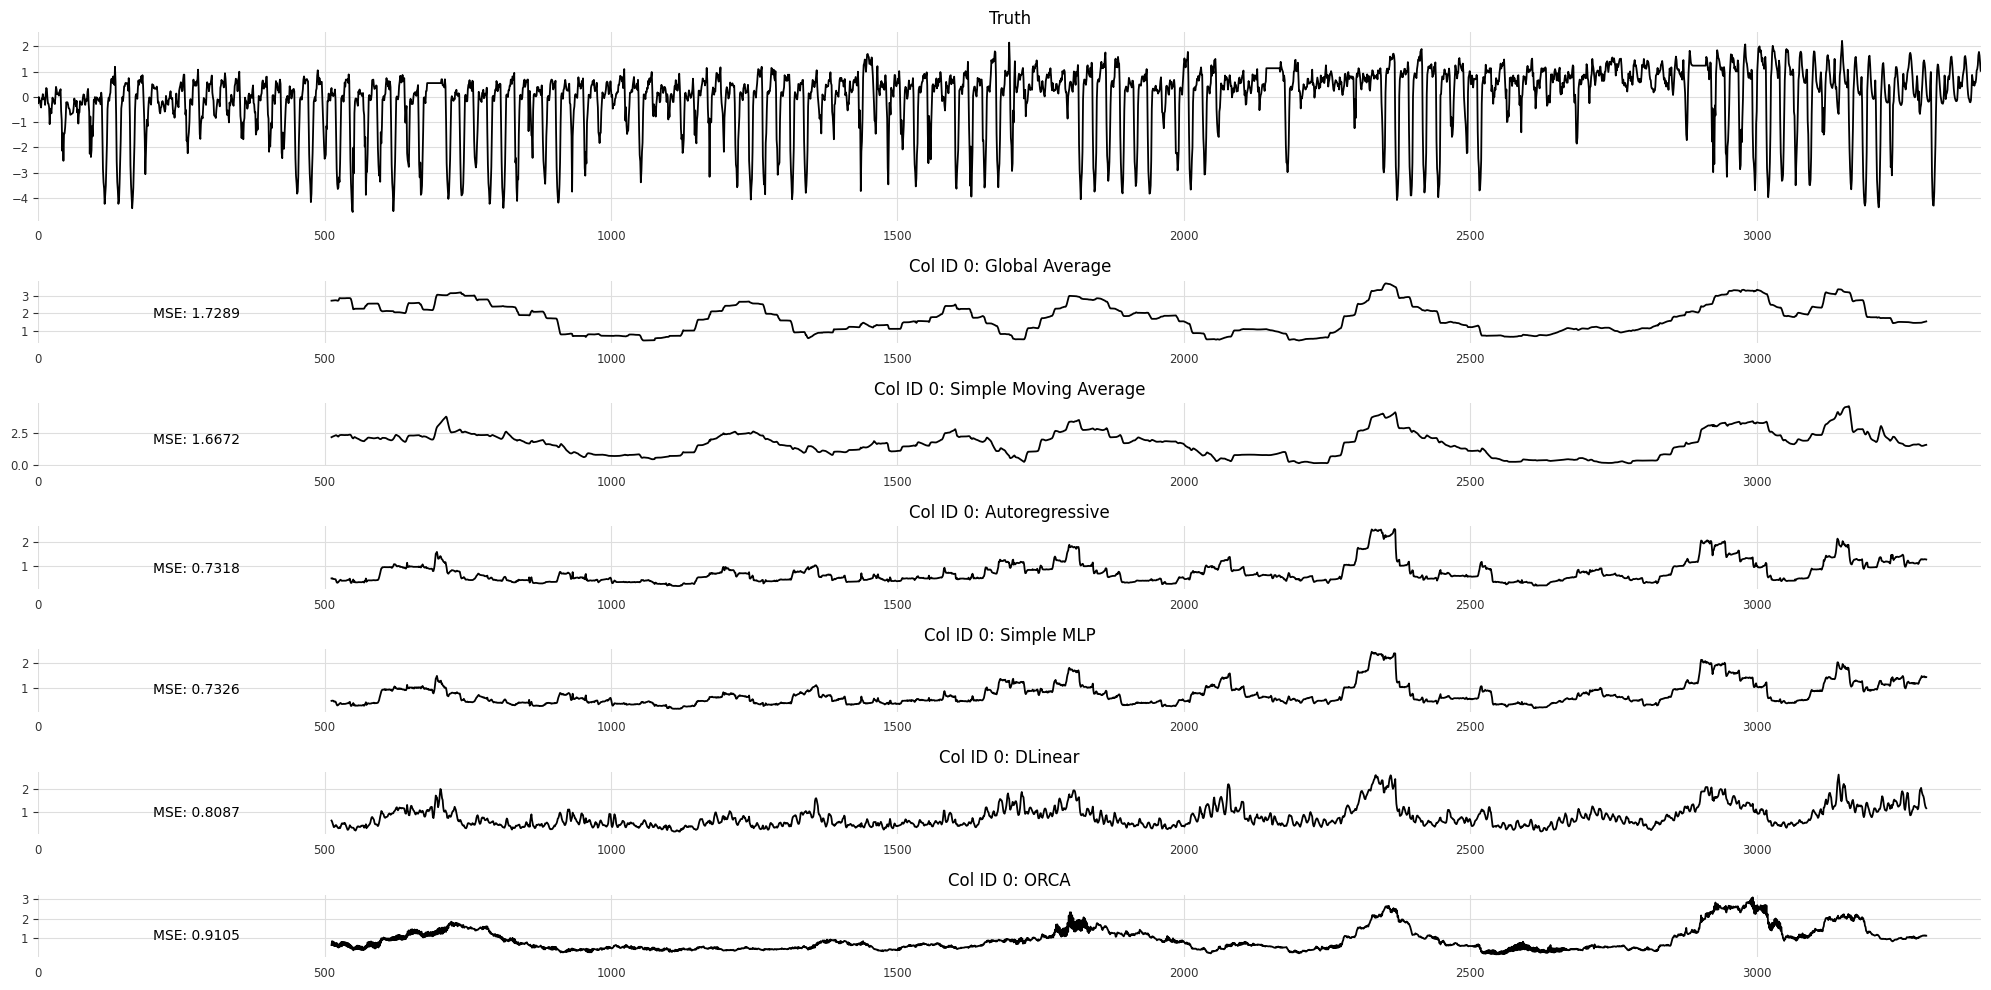

In [ ]:
def plot_mses(test_df, col_id, model_mses, model_names, input_size, output_size, start_offset = 0, end_offset = 0):
    with torch.no_grad():
        data_length = (len(test_df) - input_size - output_size + 1)
        data_id_start = int(col_id * data_length) + start_offset
        data_id_end = int((col_id + 1) * data_length) - end_offset
        fig, ax = plt.subplots(len(model_mses) + 1, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [3, *([1] * len(model_mses))]})
        i = 1
        ax[0].plot(test_df.iloc[:, col_id], label="input")
        ax[0].set_xlim(start_offset, len(test_df) - end_offset)
        ax[0].set_title("Truth")
        for model_mse, model_name in zip(model_mses, model_names):
            ax[i].plot(range(input_size + start_offset, len(test_df) - output_size + 1 - end_offset), model_mse[data_id_start:data_id_end], label="MSE")
            ax[i].set_title(f"Col ID {col_id}: {model_name}")
            ax[i].set_xlim(start_offset, len(test_df) - end_offset)
            ax[i].text(start_offset + 200, np.mean(model_mse[data_id_start:data_id_end]), f"MSE: {np.mean(model_mse[data_id_start:data_id_end]):0.4f}")
            i += 1
        fig.tight_layout()

plot_mses(test_df, 0, [gm_mse, wm_mse, ar_mse, mlp_mse, dl_mse, orca_mse], model_names, 512, 96)

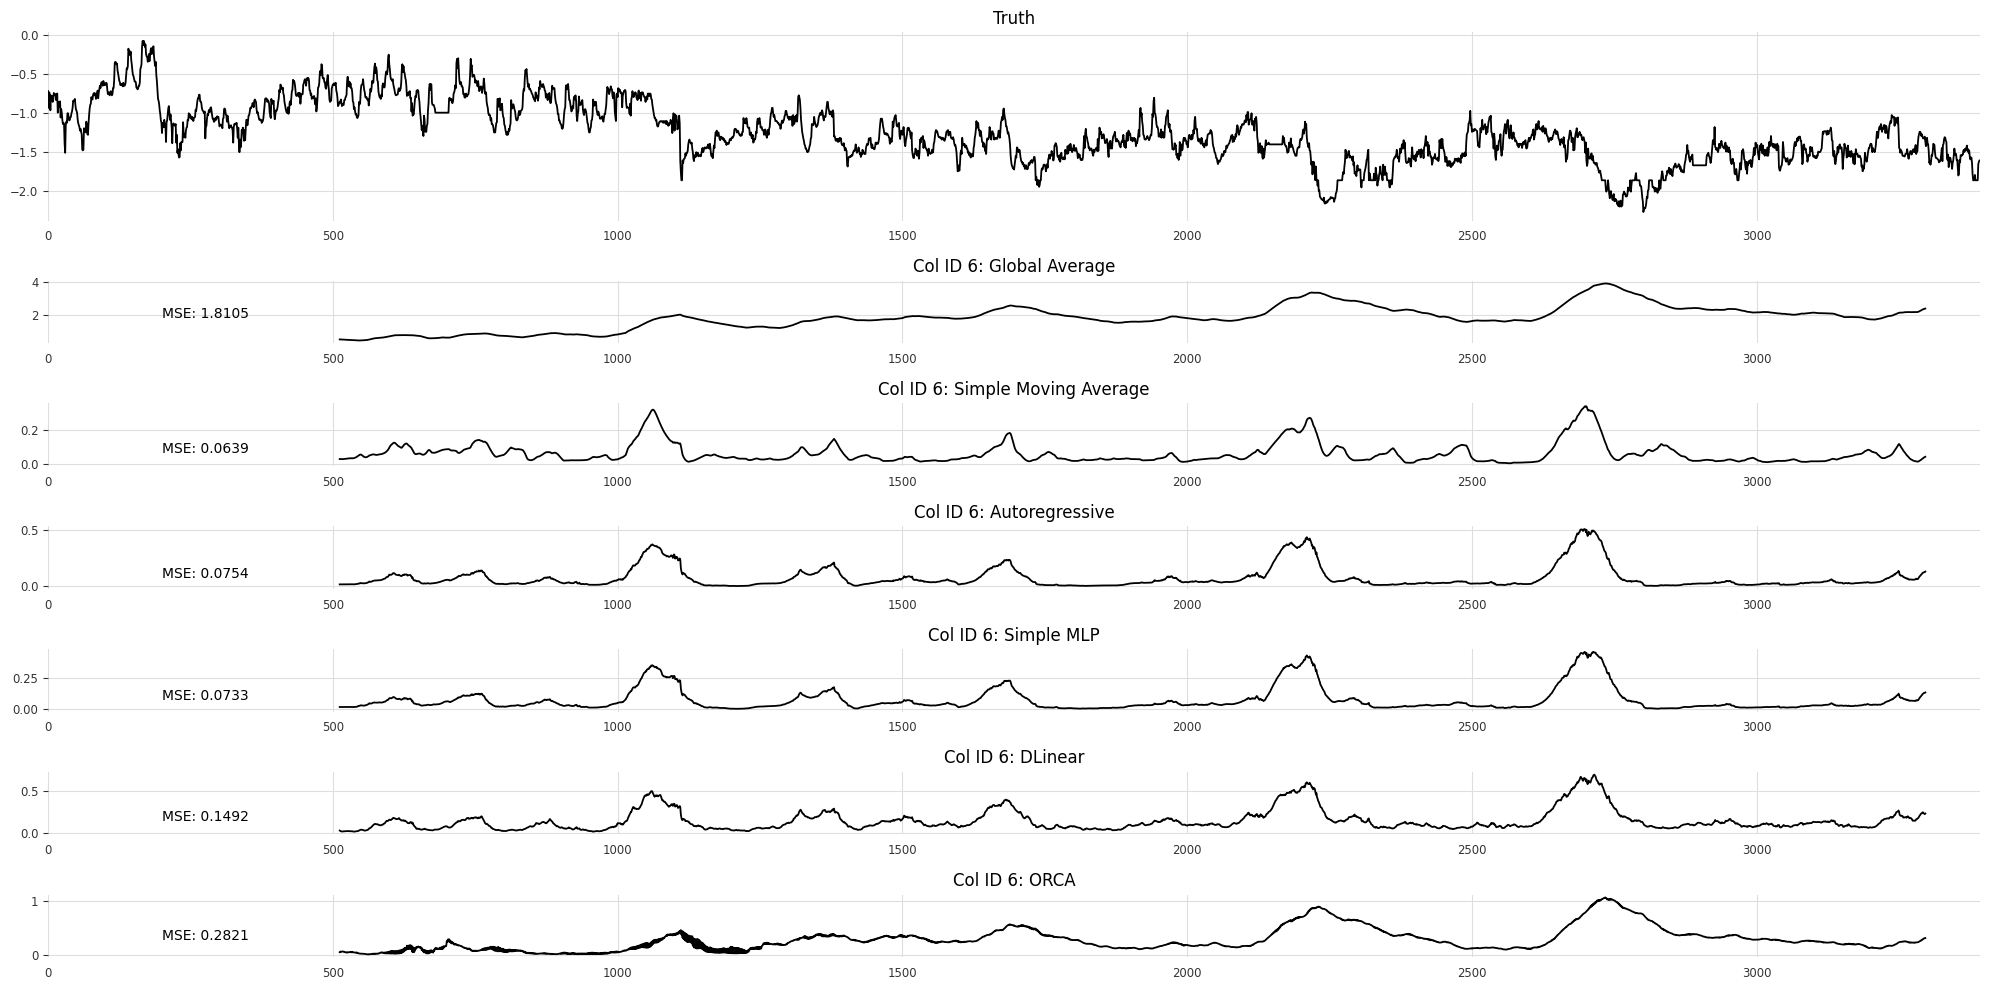

In [ ]:
plot_mses(test_df, 6, [gm_mse, wm_mse, ar_mse, mlp_mse, dl_mse, orca_mse], model_names, 512, 96)

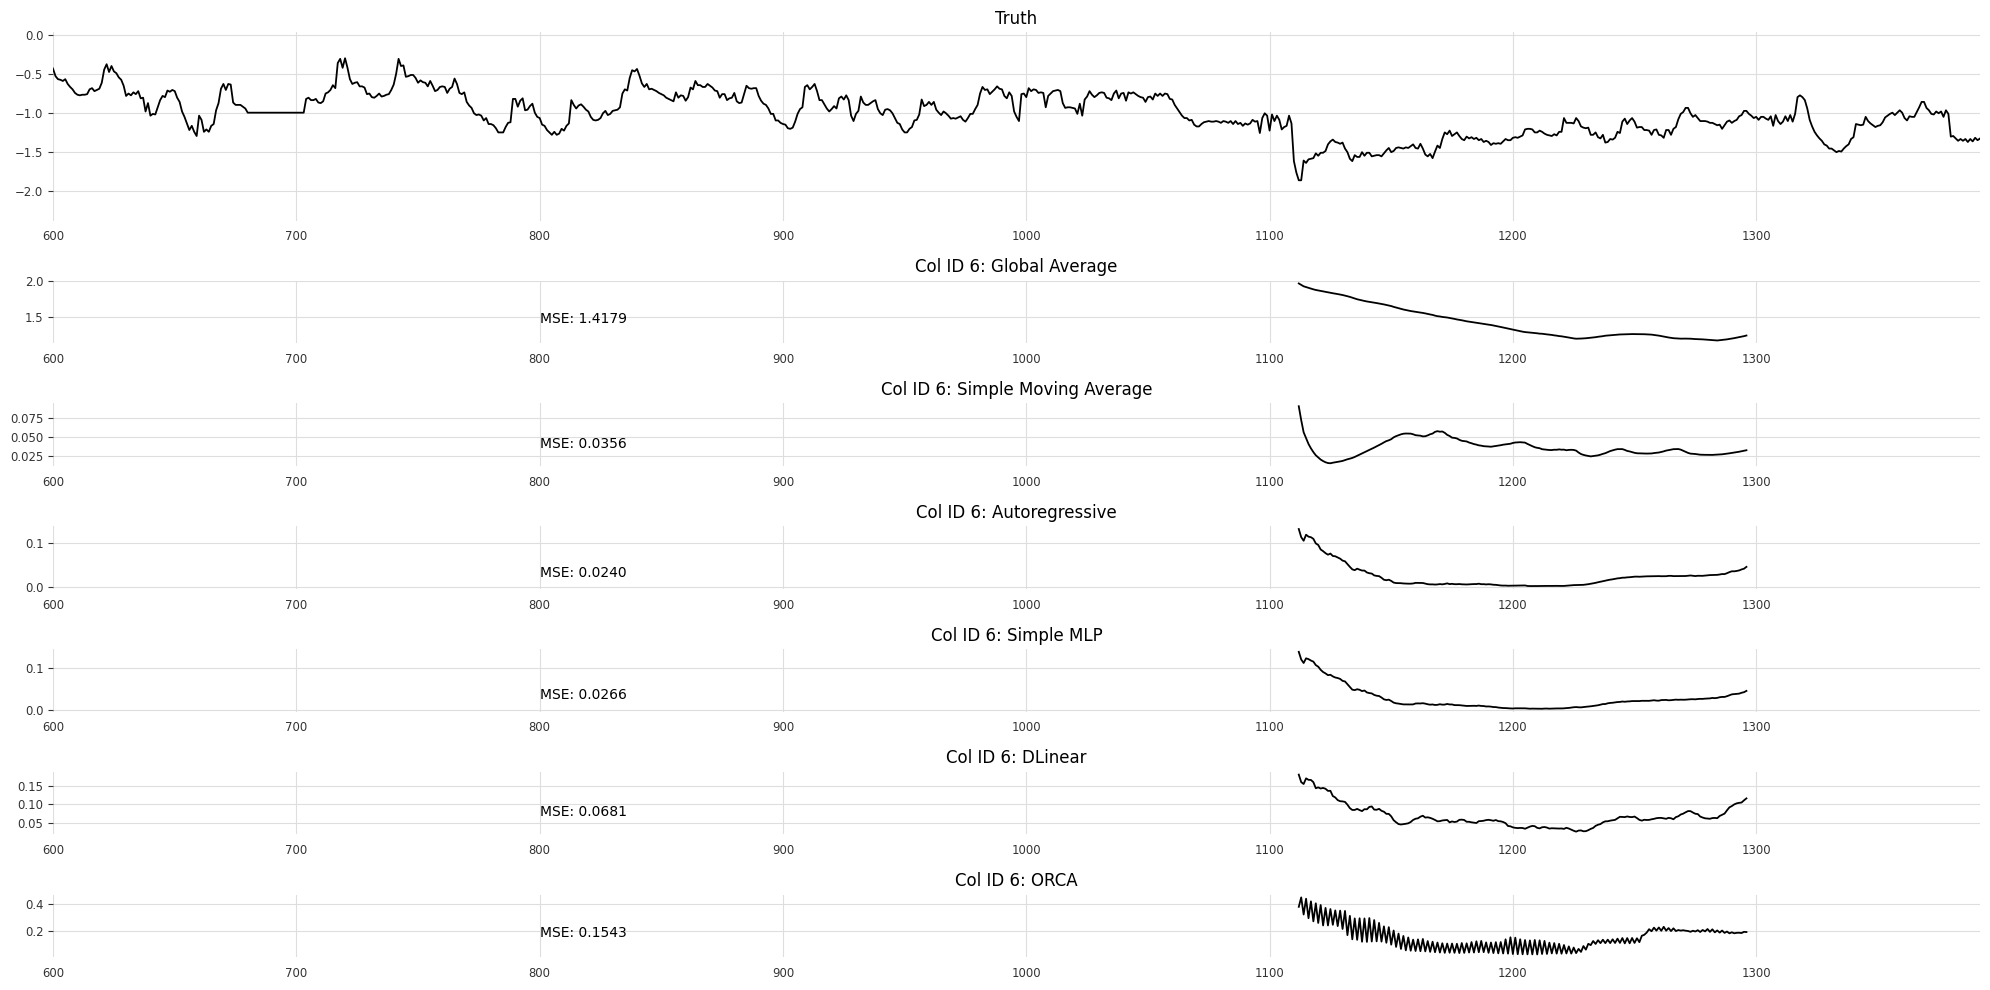

In [ ]:
plot_mses(test_df, 6, [gm_mse, wm_mse, ar_mse, mlp_mse, dl_mse, orca_mse], model_names, 512, 96, start_offset=600, end_offset = 2000)

In [28]:
import models 
import importlib
importlib.reload(models)

test_dlinear = models.SimpleDLinear(
    336, 96
)

test_dlinear.fit_raw(
    train_df,
    val_df,
    10,
    1e-3
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 32.4 K
5 | linear_trend    | Linear           | 32.4 K
-----------------------------------------------------
64.7 K    Trainable params
0         Non-trainable params
64.7 K    Total p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [31]:
test_dlinear.load_state("2024-09-05_18_19_39_torch_model_run_17060")

In [33]:
mses, maes = test_dlinear.test_loss_acc(test_data)

100%|██████████| 19495/19495 [00:39<00:00, 498.44it/s]
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [30]:
mses.mean()

0.4260928920525605

In [34]:
# best checkpoint
mses.mean()

0.41382897639399435

Batch size 32: 0.397 after 10, 0.399 best checkpoint
Batch size 8: 0.426 after 10, 0.414

In [1]:
import models 
import importlib 

importlib.reload(models)

train_loader, val_loader, test_loader = my.get_timeseries_dataloaders(
    "./datasets/all_six_datasets/ETT-small/ETTh1.csv", 32, seq_len=336, forecast_horizon=720)
test_dlinear = models.SimpleDLinear2(
    336, 720
)

test_dlinear.fit_loader(
    train_loader,
    val_loader,
    1e-5,
    10,
    None
)

NameError: name 'my' is not defined

In [32]:
import models

test = models.ARv2(96, 24)
test.fit_raw(train_df.loc[:, 0:4], val_df.loc[:, 0:4], torch.device("cuda:0"), 5, False)


5 hours limit


  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:01<00:00, 71.93it/s] 

Selected Lags: 96


In [33]:
test.test_loss_acc_df(test_df.loc[:, 0:4], torch.device("cuda:0"))

(1.1794089078903198, 0.6172557473182678)

In [8]:
test._unfold_df(train_df[0], torch.device("cuda:0")).shape

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [17]:
test_dlinear.test_loss_acc_loader(test_loader, test_dlinear.device)

Evaluating: 100%|██████████| 473/473 [00:00<00:00, 516.74it/s]


(tensor(0.4676, device='cuda:0'), tensor(0.4873, device='cuda:0'))

In [22]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([32, 1, 512])


In [21]:
x

tensor([[[ 0.5372,  0.4896,  0.5372,  ...,  0.3436,  0.5372,  1.0211]],

        [[-0.1883, -0.0095, -0.6944,  ..., -0.6348, -0.5752, -0.2479]],

        [[ 1.6270,  1.3290,  1.0017,  ..., -0.1883, -0.0691,  0.0794]],

        ...,

        [[ 0.7315,  0.8597,  0.7636,  ..., -0.1660, -1.1272, -0.9990]],

        [[-0.8067, -0.6785, -0.5182,  ..., -0.2938, -0.1019, -0.8708]],

        [[-0.1670, -0.1221,  0.0711,  ...,  0.0325,  0.1484, -0.1670]]])

In [20]:
x.permute(0, 2, 1)

tensor([[[ 0.5372],
         [ 0.4896],
         [ 0.5372],
         ...,
         [ 0.3436],
         [ 0.5372],
         [ 1.0211]],

        [[-0.1883],
         [-0.0095],
         [-0.6944],
         ...,
         [-0.6348],
         [-0.5752],
         [-0.2479]],

        [[ 1.6270],
         [ 1.3290],
         [ 1.0017],
         ...,
         [-0.1883],
         [-0.0691],
         [ 0.0794]],

        ...,

        [[ 0.7315],
         [ 0.8597],
         [ 0.7636],
         ...,
         [-0.1660],
         [-1.1272],
         [-0.9990]],

        [[-0.8067],
         [-0.6785],
         [-0.5182],
         ...,
         [-0.2938],
         [-0.1019],
         [-0.8708]],

        [[-0.1670],
         [-0.1221],
         [ 0.0711],
         ...,
         [ 0.0325],
         [ 0.1484],
         [-0.1670]]])

# AR Improvements

In [ ]:
from models import TSForecaster

class ARv2(TSForecaster):
    def fit_raw(self, scaled_train_df, scaled_val_df, device):
        train_series = np.transpose(scaled_train_df.to_numpy()).flatten()
        val_series_rw = self._unfold_df(scaled_val_df, device)
        self.mses = list()
        for lags in tqdm(range(self.input_length + 1)):
            model = AutoReg(
                endog=train_series,
                lags=lags,
                trend='c'
            ).fit()

            val_mse, _ = self.test_loss_acc_stack(model, val_series_rw, device)
            self.mses.append(val_mse)

        self.fit_preset(pd.concat((scaled_train_df, scaled_val_df)), np.argmin(self.mses))

    def _unfold_df(self, df, device):
        data = torch.tensor(np.transpose(test_df.to_numpy()), dtype=torch.float32, device=device)
        return data.unfold(1, self.input_length + self.output_length, 1)

    def fit_preset(self, scaled_train_df, lags):
        self.lags = lags
        train_series = np.transpose(scaled_train_df.to_numpy()).flatten()
        self.model = AutoReg(
                endog=train_series,
                lags=self.lags,
                trend='c'
        ).fit()
        print(f"Selected Lags: {self.lags}")

    def test_loss_acc_stack(self, model, val_series_rw, device: torch.device) -> float:
        constant = model.params[0]

        if model.ar_lags is None:
            return ((val_series_rw[:, -self.output_length:] - constant)**2).mean().item()
        
        lags = len(model.ar_lags)
        lag_params = torch.tensor(np.flip(model.params[1:], axis=0).copy(), dtype=torch.float32, device=device)
        assert len(lag_params) == lags


        val_preds = torch.zeros(val_series_rw.shape[0], val_series_rw.shape[1], self.output_length, dtype=torch.float32, device=device)
        for t in range(self.output_length):
            if t == 0:
                val_preds[:, :, t] = (val_series_rw[:, :, -lags - self.output_length:-self.output_length] * lag_params).sum(dim=-1) 
            elif t < lags:
                val_preds[:, :, t] = (val_series_rw[:, :, -lags + t - self.output_length:-self.output_length] * lag_params[:-t]).sum(dim=-1) + (val_preds[:, :, :t] * lag_params[-t:]).sum(dim=-1)
            else:
                val_preds[:, :, t] = (val_preds[:, :, t-lags:t] * lag_params).sum(dim=-1)
        val_preds = val_preds + constant 
        return ((val_preds - val_series_rw[:, :, -self.output_length:])**2).mean().item(), torch.abs(val_preds - val_series_rw[:, :, -self.output_length:]).mean().item()
    
    def test_loss_acc_df(self, scaled_test_df, device: torch.device):
        test_series_rw = self._unfold_df(scaled_test_df, device)
        return self.test_loss_acc_stack(self.model, test_series_rw, device)

    def predict(self, input) -> torch.Tensor:
        preds = self.model.append(input.flatten(), refit=False).forecast(steps=self.output_length)
        return torch.tensor(preds)

In [ ]:
test_v2 = ARv2(512, 96)
# test_v2.fit_raw(train_df, val_df, torch.device("cuda:0")) # 457 # 512
test_v2.fit_preset(pd.concat((train_df, val_df)), 512)
test_v2.test_loss_acc_df(test_df, torch.device("cuda:0"))

Selected Lags: 512


(0.3608885407447815, 0.39259371161460876)

# AR Baselines

In [ ]:
%matplotlib inline
import external_ts.my_extract as my 
import statsforecast as sf
import statsforecast.models as sfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle as pkl
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm

# SOILED IT
filenames = [
    "ETT-small/ETTh1.csv",
    "ETT-small/ETTh2.csv",
    "ETT-small/ETTm1.csv",
    "ETT-small/ETTm2.csv",
    "electricity/electricity.csv",
    "exchange_rate/exchange_rate.csv",
    "illness/national_illness.csv",
    "traffic/traffic.csv",
    "weather/weather.csv"
]

ili_horizons = [24, 36, 48, 60]
other_horizons = [96, 192, 336, 720]
DEVICE = torch.device("cuda:0")


result_filename = "armlp_results.pkl"
try:
    with open(result_filename, "rb") as file:
        results_dict = pkl.load(file)
except FileNotFoundError:
    results_dict = dict()

for filename in filenames:
    horizons = ili_horizons if "illness" in filename else other_horizons
    input_length = 96 if "illness" in filename else 512
    max_epochs = 200
    for h, horizon in enumerate(horizons):
        train_loader, val_loader, test_loader = my.get_timeseries_dataloaders(f"./datasets/all_six_datasets/{filename}", 32, forecast_horizon=horizon)
        train_data, val_data, test_data = train_loader.dataset, val_loader.dataset, test_loader.dataset
        train_df, val_df, test_df = pd.DataFrame(train_data.data), pd.DataFrame(val_data.data), pd.DataFrame(test_data.data)
        ar_key = (filename, horizon, "AR")
        mlp_key = (filename, horizon, "MLP")

        print(filename, horizon)

        if ar_key not in results_dict:
            ar = ARv2(input_length, horizon)
            ar.fit_raw(train_df, val_df, None)

            ar_mse, ar_mae = ar.test_loss_acc(test_data)
            print(filename, np.mean(ar_mse), np.mean(ar_mae))
            results_dict[ar_key] = (ar.lags, np.mean(ar_mse), np.mean(ar_mae))

        if mlp_key not in results_dict or "weather" in filename:
            dumb_mlp = DumbMLP4TS(512, horizon, torch.device("cuda:0"))
            best_val_epoch = dumb_mlp.fit_loader(train_loader, val_loader, 1e-5, max_epochs, do_print=False)
            dumb_mlp.mlp.eval()
            mlp_mse, mlp_mae = dumb_mlp.test_loss_acc_loader(test_loader, dumb_mlp.device)
            print(filename, np.mean(mlp_mse), np.mean(mlp_mae))
            results_dict[mlp_key] = (best_val_epoch, np.mean(mlp_mse), np.mean(mlp_mae))

        with open(result_filename, "wb") as file:
            pkl.dump(results_dict, file)


ETT-small/ETTh1.csv 96
ETT-small/ETTh1.csv 192
ETT-small/ETTh1.csv 336
ETT-small/ETTh1.csv 720


In [ ]:
%matplotlib inline
import external_ts.my_extract as my 
import statsforecast as sf
import statsforecast.models as sfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm


train_loader, val_loader, test_loader = my.get_timeseries_dataloaders("./datasets/all_six_datasets/ETT-small/ETTh1.csv", 128)
train_data, val_data, test_data = train_loader.dataset, val_loader.dataset, test_loader.dataset

train_df, val_df, test_df = pd.DataFrame(train_data.data), pd.DataFrame(val_data.data), pd.DataFrame(test_data.data)

# train_df = all_df.iloc[0:int(n * train_prop), :]
# val_df = all_df.iloc[int(n * train_prop):int(n * (train_prop + val_prop)), :]
# test_df = all_df.iloc[int(n * (train_prop + val_prop)): , :]

# scaler = StandardScaler().fit(train_df.iloc[:, 1:])
# train_df.iloc[:, 1:] = scaler.transform(train_df.iloc[:, 1:])
# val_df.iloc[:, 1:] = scaler.transform(val_df.iloc[:, 1:])
# test_df.iloc[:, 1:] = scaler.transform(test_df.iloc[:, 1:])
# train_df = train_df.iloc[:2000, :]
# test_df = test_df.iloc[:2000, :]

# train_df = pd.melt(train_df, id_vars=['date'])
# val_df = pd.melt(val_df, id_vars=['date'])
# test_df = pd.melt(test_df, id_vars=['date'])

# train_df.columns = ['ds', 'unique_id', 'y']
# val_df.columns = ['ds', 'unique_id', 'y']
# test_df.columns = ['ds', 'unique_id', 'y']



In [ ]:
import models
import importlib
importlib.reload(models)
test = models.DumbMLP4TS(512, 96, torch.device("cuda:0"), "blah.pt")
# test.fit_raw(train_df, val_df, torch.device("cuda:0"), 0.001, True)
# test.test_loss_acc_df(test_df, torch.device("cuda:0"))
test.fit_loader(train_loader, val_loader, 1e-5, 300, 0.001)


0.001 hours limit


  0%|          | 0/300 [00:00<?, ?it/s]

0.001 hours have passed, time's up


  0%|          | 0/300 [00:08<?, ?it/s]

Train MSE: 0.6607 | Val MSE: 1.3388 | Val MAE: 0.8340
Best val epoch id 0


0

In [ ]:
test_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                60479
Model:                     AutoReg(4)   Log Likelihood              -25319.664
Method:               Conditional MLE   S.D. of innovations              0.368
Date:                Wed, 26 Jun 2024   AIC                          50651.327
Time:                        15:47:43   BIC                          50705.387
Sample:                             4   HQIC                         50668.113
                                60479                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.427e-05      0.001      0.010      0.992      -0.003       0.003
y.L1          -0.0130      0.004     -3.194      0.001      -0.021      -0.005
y.L2           0.0121      0.004      2.971      0.003       0.004       0.020
y.L3          -0.0079      0.004     -1.954      0.051      -0.016    2.47e-05
y.L4          -0.0205      0.004     -5.054      0.000      -0.029      -0.013
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8130           -1.8503j            2.5905           -0.1266
AR.2            1.8130           +1.8503j            2.5905            0.1266
AR.3           -2.0063           -1.7962j            2.6929           -0.3838
AR.4           -2.0063           +1.7962j            2.6929            0.3838
-----------------------------------------------------------------------------
"""

In [ ]:
preds.shape

torch.Size([7892, 1, 321])

In [ ]:
test_params = torch.tensor([0.4, 0.2, 0.1])
preds = (stack[:, :, -3:] * test_params).sum(dim=-1)[:, :, None]
concat = torch.concat([stack, preds], dim=-1)

In [ ]:
test = AutoReg(
    endog=train_df.to_numpy().flatten(),
    lags=512,
    trend='c'
)

In [ ]:
import models as mod 
import importlib 
importlib.reload(mod)
importlib.reload(my)

test = mod.AR(512, 96)
test.fit_preset(train_df, 1)
print("poof")
poof = test.test_loss_acc_loader(val_loader, torch.device("cuda:0"))

Selected Lags: 1
poof


  0%|          | 0/6360 [00:03<?, ?it/s]


In [ ]:
import cProfile

cProfile.run('poof = test.test_loss_acc_loader(val_loader, torch.device("cuda:0"))')

  0%|          | 0/6360 [00:03<?, ?it/s]

         2101 function calls (2097 primitive calls) in 3.368 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.368    3.368 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 __init__.py:7(is_available)
        1    0.000    0.000    0.000    0.000 __init__.py:89(annotate)
        2    0.000    0.000    0.000    0.000 _jit_internal.py:1102(is_scripting)
        1    0.000    0.000    0.000    0.000 _monitor.py:94(report)
        1    0.000    0.000    0.001    0.001 _ops.py:286(__call__)
        1    0.000    0.000    0.001    0.001 _ops.py:497(__call__)
        1    0.000    0.000    0.001    0.001 _tensor.py:34(wrapped)
        1    0.000    0.000    0.000    0.000 _weakrefset.py:111(remove)
        2    0.000    0.000    0.000    0.000 _weakrefset.py:17(__init__)
        2    0.000    0.000    0.000    0.000 _weakrefset.py:21(__enter__)
        2    0.000    0.000    0.000  

# Performance Profile

,Dataset,Horizon
0,ETTh1,96.0
1,ETTh1,192.0
2,ETTh1,336.0
3,ETTh1,720.0
5,ETTh2,96.0
6,ETTh2,192.0
7,ETTh2,336.0
8,ETTh2,720.0
10,ETTm1,96.0
11,ETTm1,192.0


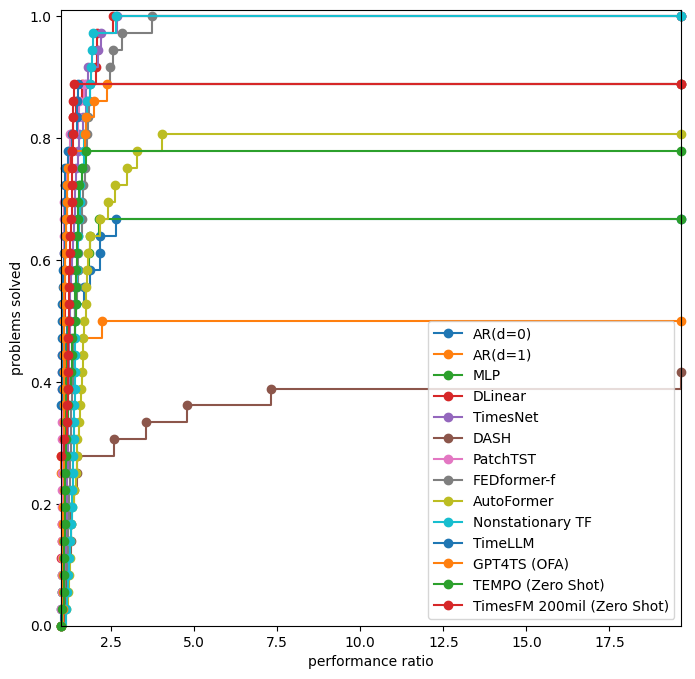

In [ ]:
import perfprof
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_excel("Dashed dreams preliminary results.xlsx", sheet_name="TS", skiprows=[0, 2, 3, 4])
data = data.iloc[:, :16]
data = data[~pd.isna(data).all(axis=1)]
data = data.rename(columns={"Unnamed: 0": "Dataset"})
data["Dataset"] = data["Dataset"].ffill()
# data = data[~pd.isna(data["Dataset"])].drop(columns=["AR(d=1)", "DASH"])
# data = data[~pd.isna(data).any(axis=1)]

fig, ax = plt.subplots(figsize=(8, 8))
_, handles = perfprof.perfprof(
    data.drop(columns=["Dataset", "Horizon"]),
    ['o-'] * 14,
)
ax.legend(labels=list(data.columns[2:]))
display(data[["Dataset", "Horizon"]])

In [ ]:
def aupp(handle_data):
    x, y = handle_data
    x_diffs = x[1:] - x[:-1]
    return (x_diffs * y[:-1]).sum()

aupp(handles[0][0].get_data())

12.227954604933075

In [ ]:
handles[0][0].get_data()

(array([ 1.        ,  1.00557103,  1.0310559 ,  1.0511509 ,  1.05965909,
         1.07159353,  1.07748184,  1.07835821,  1.08118081,  1.08709677,
         1.0913242 ,  1.09921671,  1.10294118,  1.12369942,  1.13891835,
         1.14243902,  1.1507799 ,  1.1550152 ,  1.17613636,  1.40729483,
         1.68817204,  1.86982249,  2.16118421,  2.17213115,  2.65289256,
        19.6617284 ]),
 array([0.        , 0.02777778, 0.05555556, 0.08333333, 0.11111111,
        0.13888889, 0.16666667, 0.19444444, 0.22222222, 0.25      ,
        0.27777778, 0.30555556, 0.33333333, 0.36111111, 0.38888889,
        0.41666667, 0.44444444, 0.47222222, 0.5       , 0.52777778,
        0.55555556, 0.58333333, 0.61111111, 0.63888889, 0.66666667,
        0.66666667]))

In [ ]:
data

,Dataset,Horizon,AR(d=0),AR(d=1),MLP,DLinear,TimesNet,DASH,PatchTST,FEDformer-f,AutoFormer,Nonstationary TF,TimeLLM,GPT4TS (OFA),TEMPO (Zero Shot)
0,ETTh1,96.0,0.361,0.359,0.370,0.375,0.384,0.5340,0.370,0.376,NaN,0.513,0.362,0.376,0.400
1,ETTh1,192.0,0.411,0.391,0.406,0.405,0.436,0.5014,0.413,0.420,NaN,0.534,0.398,0.416,0.426
2,ETTh1,336.0,0.445,0.413,0.440,0.439,0.493,0.4974,0.422,0.459,0.505,0.588,0.430,0.442,0.441
3,ETTh1,720.0,0.464,0.433,0.487,0.472,0.521,0.5563,0.447,0.506,0.498,0.643,0.442,0.477,0.443
5,ETTh2,96.0,0.289,0.282,0.281,0.289,0.340,0.3691,0.274,0.346,NaN,0.476,0.268,0.285,0.301
6,ETTh2,192.0,0.380,0.365,0.376,0.383,0.402,0.4282,0.341,0.429,NaN,0.512,0.329,0.354,0.355
7,ETTh2,336.0,0.463,0.399,0.461,0.448,0.452,0.8527,0.329,0.496,0.471,0.552,0.368,0.373,0.379
8,ETTh2,720.0,0.628,0.408,0.692,0.605,0.462,1.3227,0.379,0.463,0.474,0.562,0.372,0.406,0.409
10,ETTm1,96.0,0.300,0.300,0.304,0.299,0.338,NaN,0.293,0.379,0.481,0.386,0.272,0.292,0.438
11,ETTm1,192.0,0.337,0.336,0.336,0.335,0.374,NaN,0.333,0.426,NaN,0.459,0.310,0.332,0.461


,Dataset,Horizon
0,ETTh1,96.0
1,ETTh1,192.0
2,ETTh1,336.0
3,ETTh1,720.0
5,ETTh2,96.0
6,ETTh2,192.0
7,ETTh2,336.0
8,ETTh2,720.0
30,ILI,24.0
31,ILI,36.0


Text(0.5, 1.0, 'Deep Learning Methods (12 tasks)')

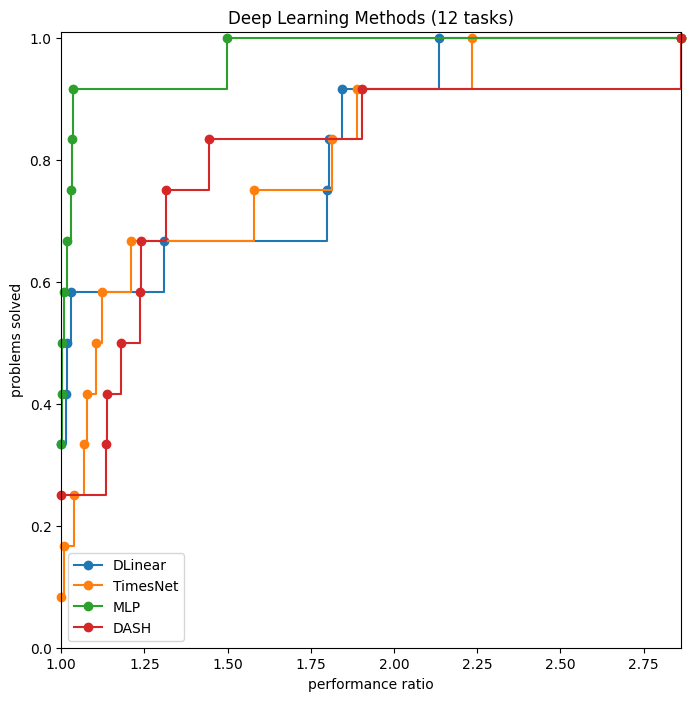

In [ ]:
def aupp(handle_data):
    x, y = handle_data
    x_diffs = x[1:] - x[:-1]
    return (x_diffs * y[:-1]).sum()

def make_pp(data, methods_list):
    filtered_data = data.copy()
    filtered_data = filtered_data[~pd.isna(filtered_data["Dataset"])][["Dataset", "Horizon"] + methods_list]
    filtered_data = filtered_data[~pd.isna(filtered_data).any(axis=1)]


    fig, ax = plt.subplots(figsize=(8, 8))
    _, handles = perfprof.perfprof(
        filtered_data.drop(columns=["Dataset", "Horizon"]),
        ['o-'] * 11,
    )

    aupps = [aupp(h[0].get_data()) for h in handles]
    ax.legend(labels=list(filtered_data.columns[2:]))
    display(filtered_data[["Dataset", "Horizon"]])
    return ax, len(filtered_data), aupps, methods_list[np.argmax(aupps)]

stats_methods = ["AR(d=0)", "AR(d=1)"]
dl_methods = ["DLinear", "TimesNet", "MLP", "DASH"]
dl_non_dash = ["DLinear", "TimesNet", "MLP"]
tf_methods = ["PatchTST", "FEDformer-f", "AutoFormer", "Nonstationary TF"]
fm_methods = ["TimeLLM", "GPT4TS (OFA)", "TEMPO (Zero Shot)", "TimesFM 200mil (Zero Shot)"]

data["Best-per-task Stats"] = data[stats_methods].min(axis=1)
data["Best-per-task FM"] = data[fm_methods].min(axis=1)
data["Best-per-task DL"] = data[dl_non_dash].min(axis=1)
data["Best-per-task TF"] = data[tf_methods].min(axis=1)


ax, num_problems, aupps, best_dl = make_pp(data, dl_methods)
ax.set_title(f"Deep Learning Methods ({num_problems} tasks)")

,Dataset,Horizon
0,ETTh1,96.0
1,ETTh1,192.0
2,ETTh1,336.0
3,ETTh1,720.0
5,ETTh2,96.0
6,ETTh2,192.0
7,ETTh2,336.0
8,ETTh2,720.0
10,ETTm1,96.0
11,ETTm1,192.0


Text(0.5, 1.0, 'Statistical Methods (18 tasks)')

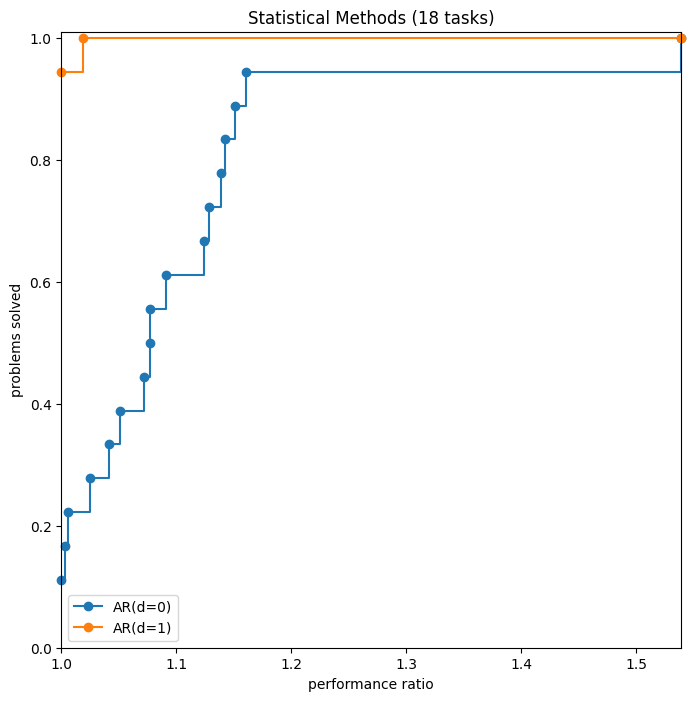

In [ ]:
ax, num_problems, _, best_stats = make_pp(data, stats_methods)
ax.set_title(f"Statistical Methods ({num_problems} tasks)")

,Dataset,Horizon
2,ETTh1,336.0
3,ETTh1,720.0
7,ETTh2,336.0
8,ETTh2,720.0
10,ETTm1,96.0
15,ETTm2,96.0
16,ETTm2,192.0
17,ETTm2,336.0
18,ETTm2,720.0
20,Weather,96.0


Text(0.5, 1.0, 'Transformer-based Methods (25 tasks)')

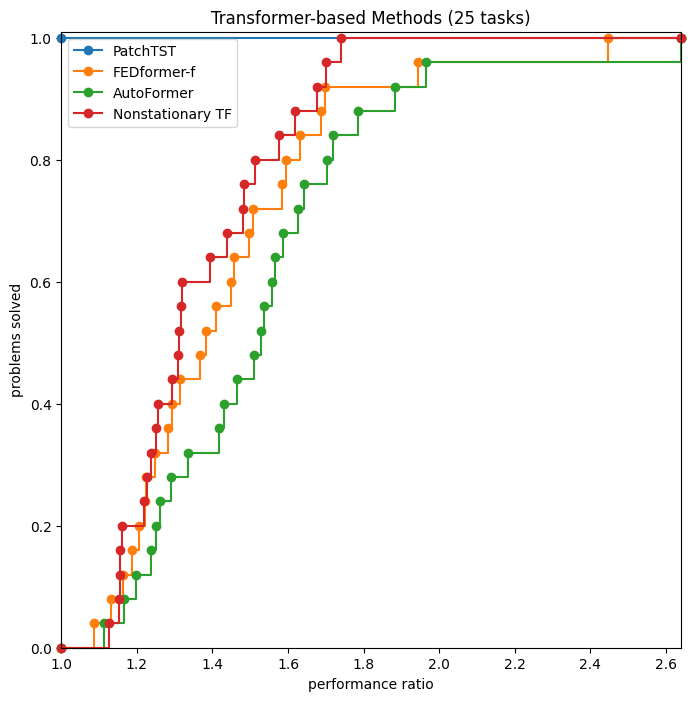

In [ ]:
ax, num_problems, _, best_tf = make_pp(data, tf_methods)
ax.set_title(f"Transformer-based Methods ({num_problems} tasks)")

,Dataset,Horizon
0,ETTh1,96.0
1,ETTh1,192.0
2,ETTh1,336.0
3,ETTh1,720.0
5,ETTh2,96.0
6,ETTh2,192.0
7,ETTh2,336.0
8,ETTh2,720.0
10,ETTm1,96.0
11,ETTm1,192.0


Text(0.5, 1.0, 'LLM/FM Methods (28 tasks)')

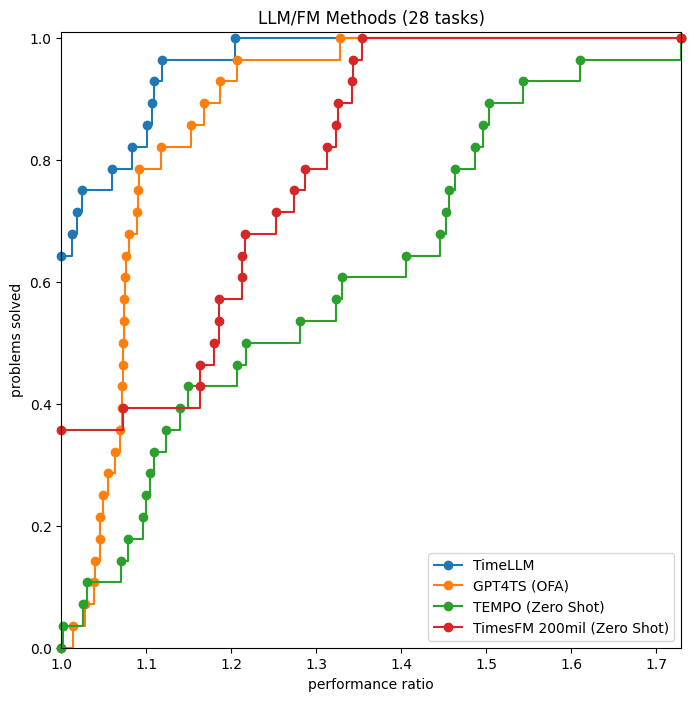

In [ ]:
ax, num_problems, _, best_fm = make_pp(data, fm_methods)
ax.set_title(f"LLM/FM Methods ({num_problems} tasks)")

,Dataset,Horizon
0,ETTh1,96.0
1,ETTh1,192.0
2,ETTh1,336.0
3,ETTh1,720.0
5,ETTh2,96.0
6,ETTh2,192.0
7,ETTh2,336.0
8,ETTh2,720.0
30,ILI,24.0
31,ILI,36.0


Text(0.5, 1.0, 'DASH vs best-per-task in category')

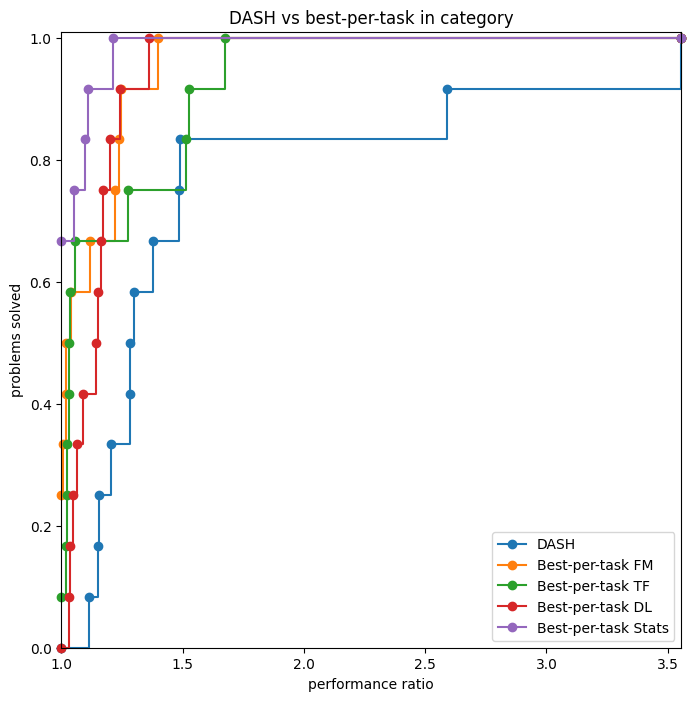

In [ ]:
ax, num_problems, _, _ = make_pp(data, ["DASH", "Best-per-task FM", "Best-per-task TF", "Best-per-task DL", "Best-per-task Stats"])
ax.set_title("DASH vs best-per-task in category")

,Dataset,Horizon
0,ETTh1,96.0
1,ETTh1,192.0
2,ETTh1,336.0
3,ETTh1,720.0
5,ETTh2,96.0
6,ETTh2,192.0
7,ETTh2,336.0
8,ETTh2,720.0
30,ILI,24.0
31,ILI,36.0


Text(0.5, 1.0, 'DASH vs best-overall in category (12 Tasks)')

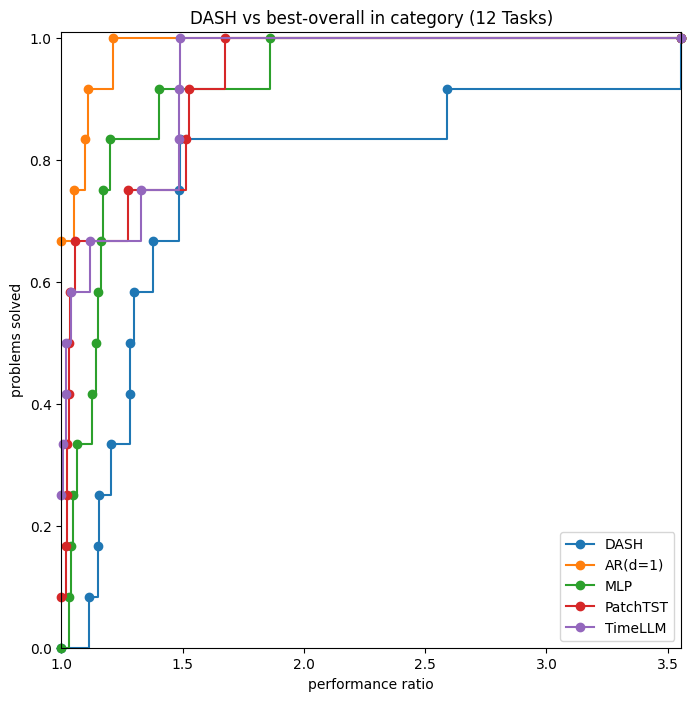

In [ ]:
ax, num_problems, final_aupps, _ = make_pp(data, ["DASH", best_stats, best_dl, best_tf, best_fm])
ax.set_title(f"DASH vs best-overall in category ({num_problems} Tasks)")

In [ ]:
final_aupps

[1.9728659922955718,
 2.5163783738431094,
 2.35570139188445,
 2.3717317215336915,
 2.3895030171807856]